<a href="https://colab.research.google.com/github/janzaw04/myTestRep/blob/main/Kopia_notatnika_cwiczenia_1a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Przykład z wykładu prof. Broniowskiego**
Inżynieria danych 2019/20
Wersja z 18.04.2020

# Sieć neuronowa

# Importowane pakiety

In [3]:
import math  as m
import numpy as np

# liczby losowe
import random

# grafika do wykresów
import matplotlib.pyplot as plt
import matplotlib as mpl

# działania na łańcuchach znaków
import string 

# statystyka
import statistics as st

# pomar czasu
import time

# dopasowywanie krzywych do danych
from scipy.optimize import curve_fit

# wyświetlanie importowanej grafiki
from IPython.display import display, Image

# wykresy konturowe
import matplotlib.cm as cm

# Funkcje rysujące sieć neuronową

In [4]:
def plot_net(n_war):
    """Narysuj szkielet sieci"""
    li_war=len(n_war)
    plt.figure(figsize=(7,4)) # rozmiar rysunku

    for i in range(li_war): # pętla po warstwach
        for j in range(1,n_war[i]): # pętla po węzłach innych niż progowe w warstwie (zaczynamy od 1)
            plt.scatter(i, j-n_war[i]/2, s=100,c='blue') 
            # rysuj punkt o współrzędnej poziomej i oraz współrzędnej pionowej rosnącej z j 
            # odjęcie n_war[i]/2 powoduje, że średnie pionowe połozenie punktów jest 0
        
    for i in range(li_war-1): # pętla po warstwach z wyjatkiem outputowej
            plt.scatter(i, 0-n_war[i]/2, s=100,c='gray') # dodaj węzły progowe innym kolorem
    
    for i in range(li_war-1): # pętla po warstwach z wyjątkim ostatniej
        for j in range(n_war[i]): # pętla po węzłach, z których wychodzi krawędź
            for k in range(n_war[i+1]-1):  # pętla po węzłach z kolejnej wartwy, do których wchodzi krawędź
                plt.plot([i,i+1],[j-n_war[i]/2,k+1-n_war[i+1]/2],c='gray') # rysowanie krawędzi
                # współrzędne odpowiadają współrzędnym punktu

    plt.title("Sieć o inpucie i " + str(li_war-1)+" warstwach",fontsize=16)

    plt.axis("off")
    plt.show()

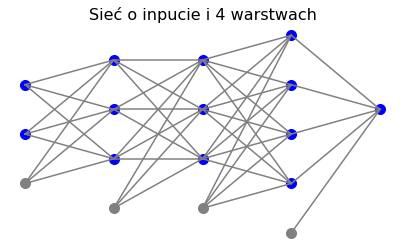

In [5]:
plot_net([3,4,4,5,2])

In [6]:
def plot_net_w(n_war, wagi):
    """Narysuj sieć z wagami"""
    li_war=len(n_war)
    plt.figure(figsize=(7,4)) # rozmiar rysunku

    for i in range(li_war): # pętla po warstwach
        for j in range(1,n_war[i]): # pętla po węzłach innych niż progowe w warstwie (zaczynamy od 1)
            plt.scatter(i, j-n_war[i]/2, s=100,c='blue') 
            # rysuj punkt o współrzędnej poziomej i oraz współrzędnej pionowej rosnącej z j 
            # odjęcie n_war[i]/2 powoduje, że średnie pionowe połozenie punktów jest 0
        
    for i in range(li_war-1): # pętla po warstwach z wyjatkiem outputowej
            plt.scatter(i, 0-n_war[i]/2, s=100,c='gray') # dodaj węzły progowe innym kolorem
    
    li_par=0 #liczba wag
    
    for i in range(li_war-1):
        for j in range(n_war[i]):
            for k in range(n_war[i+1]-1):
                li_par+=1
                th=3*wagi[i+1][j][k]
                if th>0:
                    col='red'
                else:
                    col='blue'
                th=abs(th)
                plt.plot([i,i+1],[j-n_war[i]/2,k+1-n_war[i+1]/2],c=col,linewidth=th)
                

    plt.title("Sieć o inpucie i "+str(li_war-1)+" warstwach (liczba wag: "+str(li_par)+")",fontsize=16)

    plt.axis("off")
    plt.show()

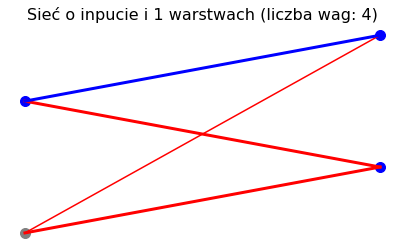

In [7]:
plot_net_w([2,3],{1:[[1,.5],[1,-1]]})

### Inicjalizowanie losowe wag

In [8]:
# skrót dla generowania liczby losowej w przedziale (-0.5,0.5)
def rn():
    return random.random()-0.5

In [9]:
# losowe wagi z przedziału (-0.5,0.5)
def ran_w(n_war):
    li_war=len(n_war) 
    wa={}
    for k in range(len(n_war)-1):
        wa.update({k+1: [[rn() for i in range(n_war[k+1]-1)] for j in range(n_war[k])]})
    return wa

In [10]:
# losowe wagi z przedziału (-0.5s,0.5s)
def ran_w_s(n_war,s):
    li_war=len(n_war) 
    wa={}
    for k in range(len(n_war)-1):
        wa.update({k+1: [[s*rn() for i in range(n_war[k+1]-1)] for j in range(n_war[k])]})
    return wa

# Propagacja wsteczna (backpropagation)

In [11]:
def back_prop(dane, odp, p, n_war, wagi, eps):
    """Propagacja wsteczna"""

# dane - dane szkoleniowe:    
# tablica o liczbie kolumn = liczba węzłów w warstwie inputowej  -1 (nie liczymy węzłą progowego)
#                i liczie wierszy = liczbie punktów danych

# odp - poprawne odpowiedzi
# tablica o liczbie kolumn = liczba węzłów w warstwie outputowej -1 (nie liczymy węzłą progowego)
#                i liczbie wierszy = liczbie punktów danych

# p=0,1, ..., liczba danych-1 - numer punktu w próbce danych szkoleniowych

# n_war - tablica liczby węzłów w kolejnych warstwach od inputu poprzez pośrednie do outputu

    li_war=len(n_war) # liczba warstw (licząc wszystkie)

    po=np.insert(dane[p],0,1) # dodanie do punktu danych jedynki na początku (węzeł progowy)

    x=feed_forward_sig(n_war,wagi,po) # propagacja sygnału do przodu z sigmoidem
   
    n=n_war[li_war-1]-1  # liczba neuronów w warstwie outputowej 
    
    k=len(n_war)-2       # liczba warstw pośrednich
                         # wszystkich warstw jest k+2, są numerowane jako 0,1,2,...,k+1
                         # tj. 0 - inputowa, k+1 - outputowa, pozostałe pośrednie

    D={}                 # słownik dla wielkości D z wyprowadzenia
    
    D.update({k+1:       # D[k+1] - dla warstwy outputowej
        [2*(x[k+1][gam]-odp[p][gam-1])*dsig(np.dot(x[k],wagi[k+1]))[gam-1] for gam in range(1,n+1)]})   

    wagi[k+1]-=eps*np.outer(x[k],D[k+1]) # uaktualnienie wag prowadzących do warstwy outputowej
    
    # pętla po pozostałych warstwach po j = k, k-1, ..., 1
    for j in reversed(range(1,k+1)):            # pętla w odwrotnej kolejności
        u=np.delete(np.dot(wagi[j+1],D[j+1]),0) # implementacja wzoru z wyprowadzena
        v=dsig(np.dot(x[j-1],wagi[j]))          # ...
        D.update({j: [u[i]*v[i] for i in range(len(u))]}) # dopisanie D[j] do słownika
        wagi[j]-=eps*np.outer(x[j-1],D[j])      # uaktualnienie wag

## Ciągła funkcja wzbudzenia - sigmoidalna

Dobrze jest użyć ciągłej funkcji aktywacji. Historycznie, używano tzw. **sigmoidu**:

$\sigma(s)=\frac{1}{1+\exp(-s)}$

In [12]:
# sigmoid, inaczej funkcja logistyczna, a także (1+arctanh(-s/2))/2 
def sig(s):
    return 1/(1+np.exp(-s))

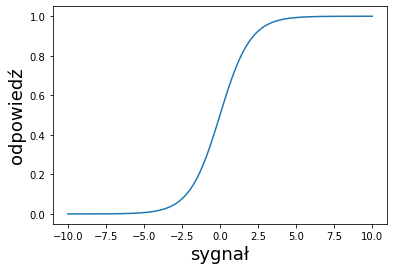

In [13]:
s = np.linspace(-10, 10, 100)

fs = [sig(z) for z in s]

plt.xlabel('sygnał',fontsize=18)
plt.ylabel('odpowiedź',fontsize=18)

plt.plot(s, fs);

Funkcja ta jest oczywiście różniczkowalna. Co więcej, 

$\sigma'(s)=\sigma(s)[1-\sigma(s)]$,

co jest jej szczególną cechą.

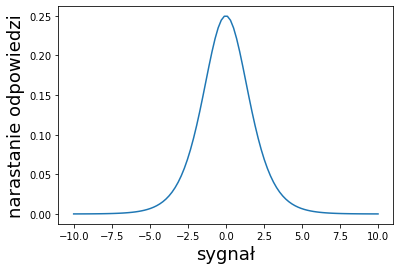

In [14]:
# pochodna sigmoidu
def dsig(s):
     return sig(s)*(1-sig(s)) # szczególna cecha tej funkcji
    
s = np.linspace(-10, 10, 100)
dfs = [dsig(z) for z in s]

plt.xlabel('sygnał',fontsize=18)
plt.ylabel('narastanie odpowiedzi',fontsize=18)

plt.plot(s, dfs);    

Funkcja propagująca sygnał w przód. Określamy ją z sigmoidem

In [15]:
def feed_forward_sig(n_war, wagi, x_in):
    """Propagacja sygnału w przód"""
    li_war=len(n_war)
    
    x={} # słownik, który będzie zawierać warości sygnałów we wszystkich warstwach
    x.update({0: np.array(x_in)}) 
    
    for i in range(1,li_war): # pętla po warstwach począwszy od pierwszej po inpucie
        a=np.dot(x[i-1],wagi[i]) # sygnał docierający do warstwy i
        b=[sig(a[q]) for q in range(len(a))] # sygnał wychodzacy z warstwy (określony przez funkcję aktywacji)
        x.update({i: np.insert(b,0,1)}) # dopisanie do słownika po wstawieniu sygnału 1 dla węzła progowego
        
    return x

# Przykład z punktami w kole


In [16]:
# zwraca losowe współrzędne x1, x2 oraz 1 dla punktów 
# w kole o środku (0.5,0.5) i promeniu 0.4, a 0 poza nim

def kolo():
    x1=random.random()
    x2=random.random()
    if((x1-0.5)*(x1-0.5)+(x2-0.5)*(x2-0.5) < 0.4*0.4): # w kole
        return np.array([x1,x2,1])
    else:                                              # poza kołem
        return np.array([x1,x2,0])


In [17]:
# nasz punkt i liczba "kontrolna" czy "klasyfikująca":, wskazująca czy jest w okręgu czy poza
kolo()

# format:  x1          x2       l. kontrolna 

array([0.68905454, 0.13981195, 0.        ])

In [18]:
# losowa próbka szkoleniowa 3000 punktów 
probka_k=np.array([kolo() for i in range(3000)])
da_k=np.delete(probka_k,2,1)
od_k=np.delete(np.delete(probka_k,0,1),0,1)

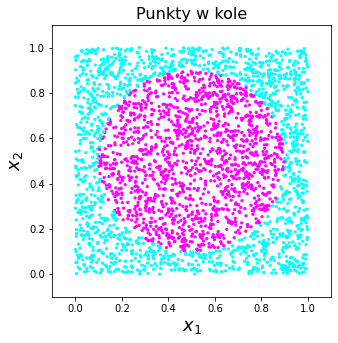

In [19]:
plt.figure(figsize=(5,5))
plt.title("Punkty w kole",fontsize=16) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.scatter(probka_k[:,0],probka_k[:,1],c=probka_k[:,2],
            s=5,cmap=mpl.cm.cool,norm=mpl.colors.Normalize(vmin=0, vmax=.9))

plt.xlabel('$x_1$',fontsize=18)
plt.ylabel('$x_2$',fontsize=18);

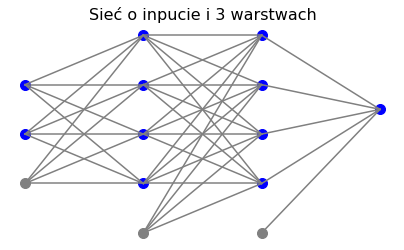

In [20]:
# sieć o dość pokaźnej liczbie neuronów
siec=[3,5,5,2]
plot_net(siec)

wagi=ran_w_s(siec,5.); # początkowe losowe wagi

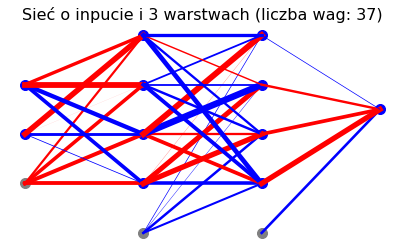

In [21]:
plot_net_w(siec,wagi)

In [22]:
# uczenie trwa dość długo, trzeba tę komórkę przepuścić wiele razy

eps=.7

for k in range(500):  # 500 rund
    eps=.99*eps
    if k%10==9:
        print(k+1,' ',end='')
    for p in range(len(probka_k)):
        back_prop(da_k,od_k,p,siec,wagi,eps)

10  20  30  40  50  60  70  80  90  100  110  120  130  140  150  160  170  180  190  200  210  220  230  240  250  260  270  280  290  300  310  320  330  340  350  360  370  380  390  400  410  420  430  440  450  460  470  480  490  500  

#### Sprawdzenie na próbce testowej

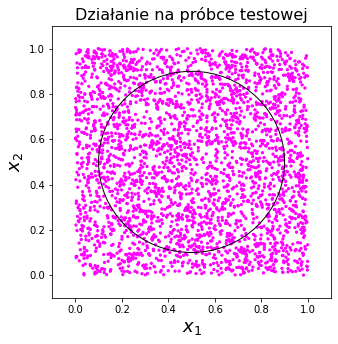

In [23]:
test=[] # próbka testowa

for k in range(3000):
    po=[1,random.random(),random.random()]  # nowy punkt testowy
    xt=feed_forward_sig(siec,wagi,po)    # generowanie wyniku dla tego punktu
    test.append([po[1],po[2],np.round(xt[3][1],0)]) # zapis do tablicy

tt=np.array(test) # zmiana formatu tablicy na numpy  

fig=plt.figure(figsize=(5,5))

# dorysowanie okręgu
ax=fig.add_subplot(1,1,1)
circ=plt.Circle((0.5,0.5), radius=.4, color='black', fill=False)
ax.add_patch(circ)

plt.title("Działanie na próbce testowej",fontsize=16) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.scatter(tt[:,0],tt[:,1],c=tt[:,2],
            s=5,cmap=mpl.cm.cool,norm=mpl.colors.Normalize(vmin=0, vmax=.9))

plt.xlabel('$x_1$',fontsize=18)
plt.ylabel('$x_2$',fontsize=18);

Komentarz: Fascynujące jest, że nauczyliśmy sieć rozpoznawać, czy punkt jest w kole, a nie ma ona pojecia o geometrii, odległości euklidesowej, równaniu okregu itd. Po prostu sieć nauczyła się tego "empirycznie".

# To samo ale z użyciem pakietu Scikit Learn https://scikit-learn.org 




# Załączone pakiety

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# `Przygotowanie danych`

In [25]:
probka_k=np.array([kolo() for i in range(6000)])
print(probka_k.shape)

(6000, 3)


# Definiuję funkcję rysującą dane

In [26]:
def draw_result(X,y): 
  fig=plt.figure(figsize=(5,5))

  # dorysowanie okręgu
  #ax=fig.add_subplot(1,1,1)
  #circ=plt.Circle((0.5,0.5), radius=.4, color='black', fill=False)
  #ax.add_patch(circ)

  plt.title("Działanie na próbce testowej",fontsize=16) 
  plt.xlim(min(X[:,0]),max(X[:,0]))
  plt.ylim(min(X[:,1]),max(X[:,1]))
  plt.scatter(X[:,0],X[:,1],c=y,
            s=5,cmap=mpl.cm.cool,norm=mpl.colors.Normalize(vmin=min(y), vmax=max(y)))

  plt.xlabel('$x_1$',fontsize=18)
  plt.ylabel('$x_2$',fontsize=18);

# Przygotowanie formatu danych

(6000, 2) (6000,)
(3000, 2) (3000,)


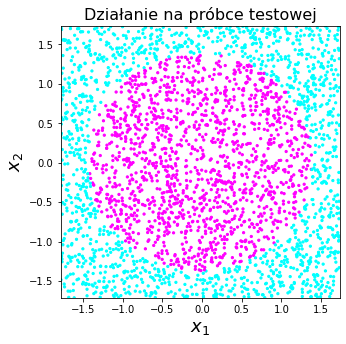

In [27]:
X, y = probka_k[:,:2], probka_k[:,2]
print(X.shape ,y.shape)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5, random_state=33)
print(X_train.shape ,y_train.shape)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

draw_result(X_test,y_test)

TENING SIECI NEURONOWEJ

In [28]:
clf = MLPClassifier(hidden_layer_sizes=(4,6),activation='relu',solver='adam',alpha=0.001,learning_rate_init=0.01,early_stopping=True,validation_fraction=0.1,max_iter=1000,verbose=True,n_iter_no_change=1000)

print(clf.fit(X_train,y_train))

print("Score train = ",clf.score(X_train,y_train))
print("Score test = ",clf.score(X_test,y_test))

Z=clf.predict_proba(X_test)[:,1]
print(Z)

Iteration 1, loss = 0.79188719
Validation score: 0.586667
Iteration 2, loss = 0.79167786
Validation score: 0.586667
Iteration 3, loss = 0.79146486
Validation score: 0.586667
Iteration 4, loss = 0.79125212
Validation score: 0.586667
Iteration 5, loss = 0.79103736
Validation score: 0.586667
Iteration 6, loss = 0.79083523
Validation score: 0.586667
Iteration 7, loss = 0.79062340
Validation score: 0.586667
Iteration 8, loss = 0.79041370
Validation score: 0.586667
Iteration 9, loss = 0.79020316
Validation score: 0.590000
Iteration 10, loss = 0.78999211
Validation score: 0.590000
Iteration 11, loss = 0.78978563
Validation score: 0.590000
Iteration 12, loss = 0.78957340
Validation score: 0.590000
Iteration 13, loss = 0.78936744
Validation score: 0.590000
Iteration 14, loss = 0.78916193
Validation score: 0.590000
Iteration 15, loss = 0.78895950
Validation score: 0.590000
Iteration 16, loss = 0.78875618
Validation score: 0.590000
Iteration 17, loss = 0.78855495
Validation score: 0.590000
Iterat

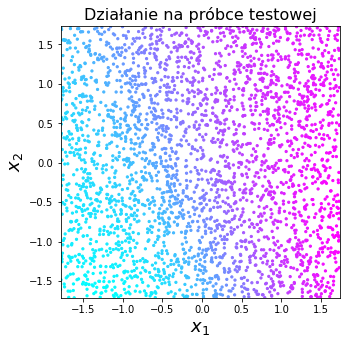

In [29]:
draw_result(X_test,Z)

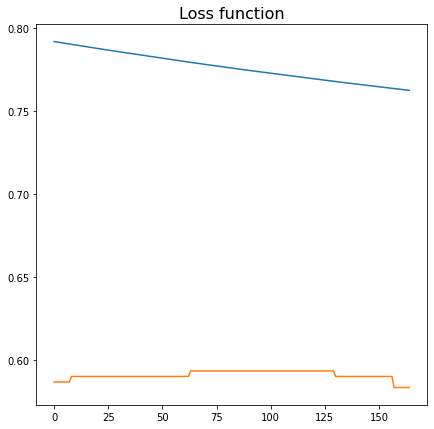

In [30]:
fig=plt.figure(figsize=(7,7))

plt.title("Loss function", fontsize=16)

plt.plot(clf.loss_curve_)
plt.plot(clf.validation_scores_)

Wizualizacja


--2020-11-17 12:08:51--  https://raw.githubusercontent.com/jzliu-100/visualize-neural-network/master/VisualizeNN.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9495 (9.3K) [text/plain]
Saving to: ‘VisualizeNN.py.1’

VisualizeNN.py.1    100%[===================>]   9.27K  --.-KB/s    in 0s      

2020-11-17 12:08:52 (60.8 MB/s) - ‘VisualizeNN.py.1’ saved [9495/9495]



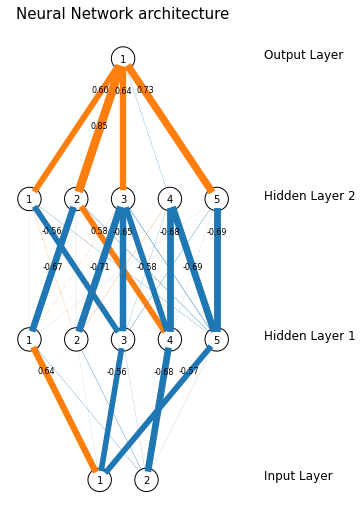

In [31]:
! wget https://raw.githubusercontent.com/jzliu-100/visualize-neural-network/master/VisualizeNN.py
import VisualizeNN as VisNN

NN = list(clf.hidden_layer_sizes)
NN.append(clf.n_outputs_)
NN.insert(0,clf.coefs_[0].shape[0])

network=VisNN.DrawNN(NN,clf.coefs_)
network.draw()